In [1]:
# !python -m venv Senspy_venv

In [4]:
# !python.exe -m pip install --upgrade pip
# !pip3 install numpy
# !pip3 install pandas
# !pip3 install seaborn
# !pip3 install matplotlib
# !pip3 install joblib
# !pip3 install scikit-learn
# !pip3 install sklearn
# !pip3 install keras
# !pip3 install pyswarm
# !pip3 install tensorflow
# !pip3 install setuptools
# !pip3 install h5py
# !pip3 install numpy==1.21.4
# !pip3 install pip install numba==0.53.0
# !pip3 install librosa
# !pip3 install hyperopt
# !pip3 install statsmodels
# !pip3 uninstall -y scikit-learn
# !pip3 install scikit-learn==1.5.2
# !pip3 install openxyl

In [ ]:
### Step 1: Create a directory structure

shell
my_ai_package/
├── my_ai_package/
│   ├── __init__.py
│   ├── parametric_studies.py
│   ├── parametric_sensitivity_analysis.py
│   └── plotting.py
├── setup.py
└── README.md



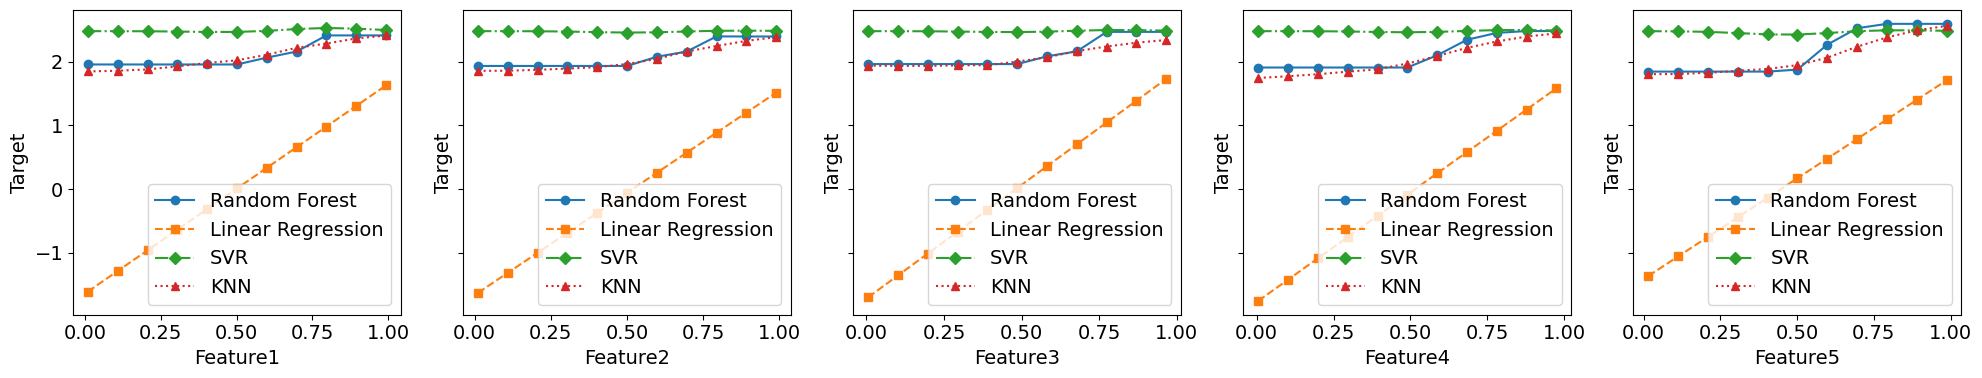

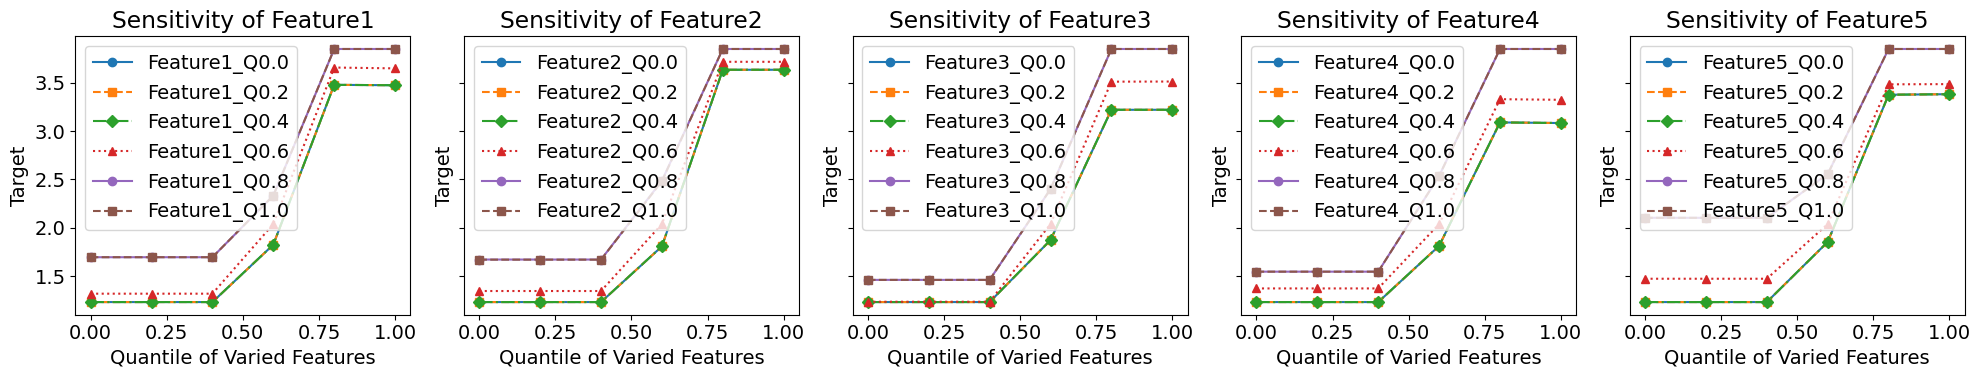

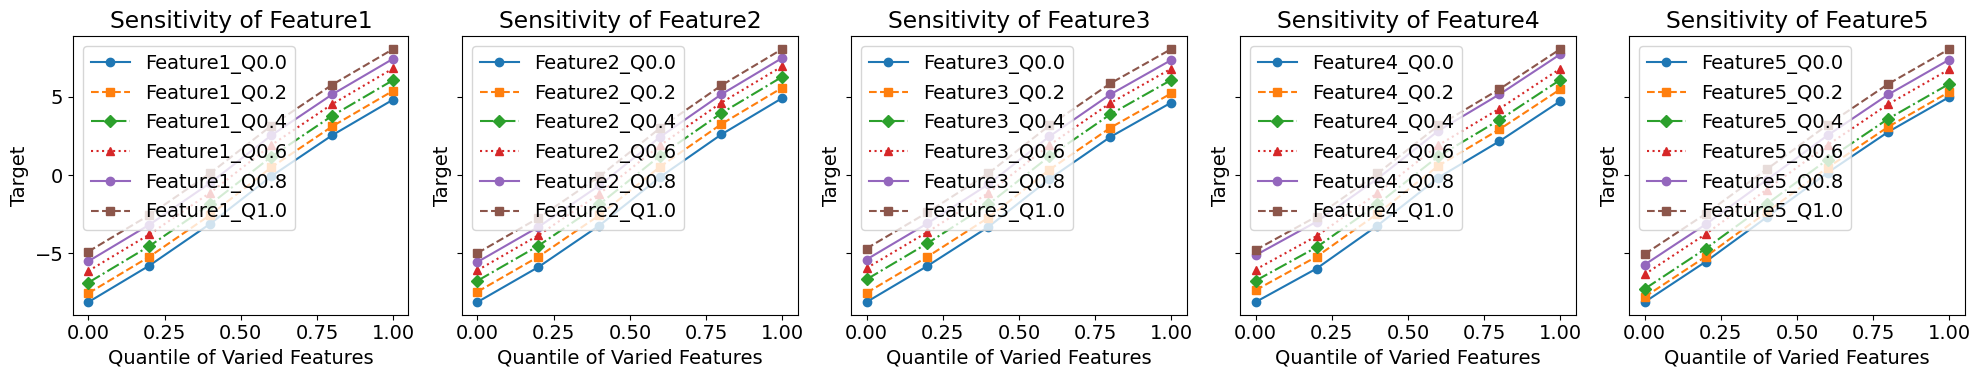

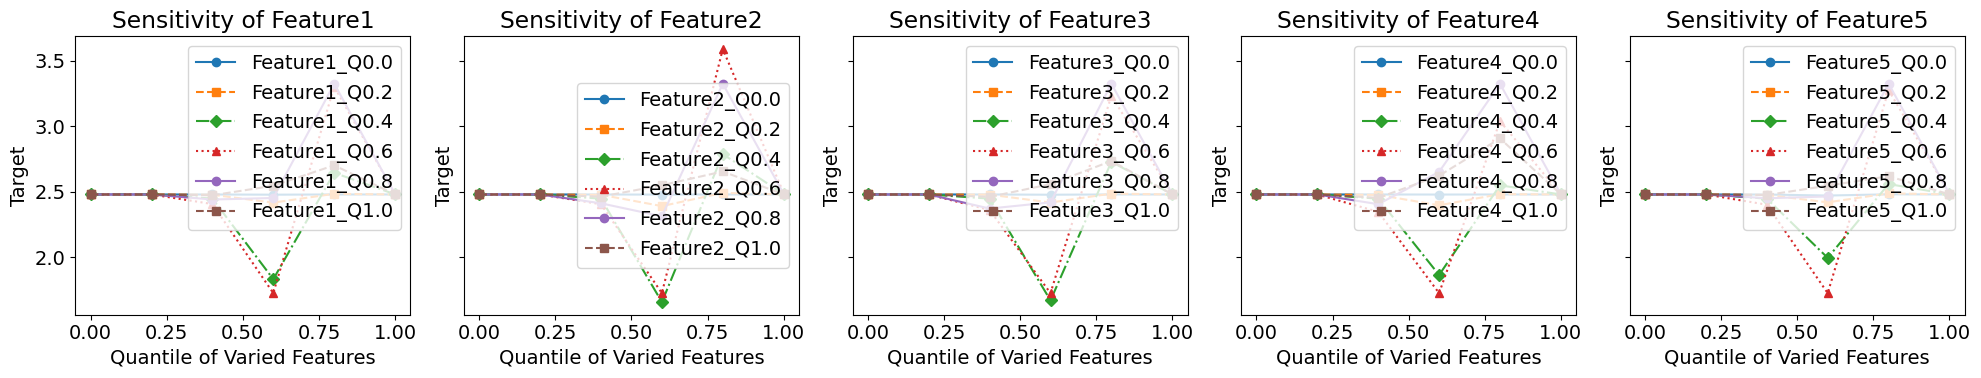

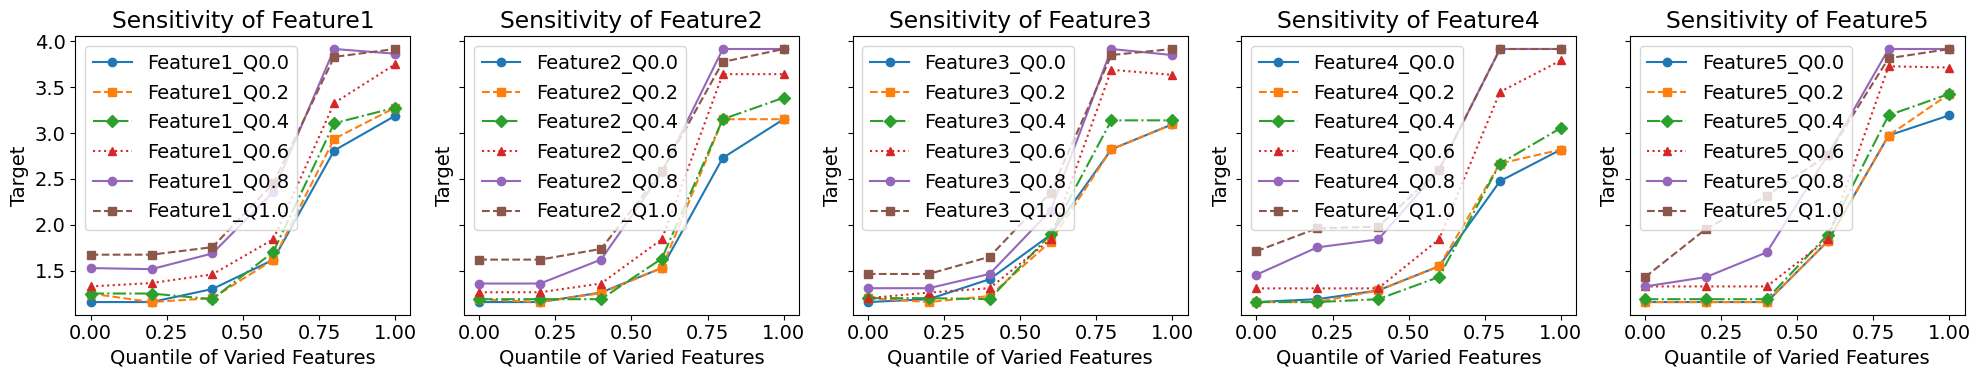

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from math import ceil, sqrt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

class SensitivityAnalysis:
    def __init__(self, model, data, feature_names, scaler=None):
        """
        Initialize the sensitivity analysis class.
        
        :param model: Trained AI model
        :param data: DataFrame containing the dataset
        :param feature_names: List of feature names
        :param scaler: Optional scaler for preprocessing
        """
        self.model = model
        self.data = data
        self.feature_names = feature_names
        self.scaler = scaler or StandardScaler()
        self.scaled_data = self.scaler.fit_transform(data)
    
    
    def parametric_study(self, models, save_path="./Output/Parametric_Study.png"):
        """
        Generate parametric study plots comparing multiple models.
        
        :param models: Dictionary of models {"ModelName": model}
        :param save_path: Path to save the plot
        """
        num_features = len(self.feature_names)
        rows = ceil(num_features/num_features) # ceil(sqrt(num_features))
        cols = ceil(num_features)  #   ceil(num_features / rows)
        
        fig, axes = plt.subplots(rows, cols, figsize=(num_features*4, 4), sharey=True)
        axes = axes.flatten()
        
        plt.rcParams.update({'font.size': 14})
        
        line_styles = ['-', '--', '-.', ':']
        markers = ['o', 's', 'D', '^']
        
        for idx, feature in enumerate(self.feature_names):
            ax = axes[idx]
            feature_range = np.linspace(self.data[feature].min(), self.data[feature].max(), 11)
            modified_data = self.data.copy()
            results = {}
            
            for model_idx, (model_name, model) in enumerate(models.items()):
                predictions = []
                for value in feature_range:
                    modified_data[feature] = value
                    scaled_input = self.scaler.transform(modified_data)
                    scaled_input = pd.DataFrame(scaled_input, columns=self.feature_names)
                    predictions.append(model.predict(scaled_input).mean())
                results[model_name] = predictions
                
            for model_idx, (model_name, preds) in enumerate(results.items()):
                ax.plot(feature_range, preds, label=model_name, linestyle=line_styles[model_idx % len(line_styles)], marker=markers[model_idx % len(markers)])
            
            ax.set_xlabel(feature)
            ax.set_ylabel('Target')
            ax.legend()
        
        for i in range(num_features, len(axes)):
            fig.delaxes(axes[i])
        
        plt.tight_layout()
        plt.savefig(save_path, dpi=300)
        plt.show()
    
    def parametric_sensitivity(self, save_path="./Output/Parametric_Sensitivity.png"):
        """
        Generate sensitivity analysis plots where one feature is fixed at each quantile 
        while all other features vary across six quantiles.
        
        :param save_path: Path to save the plot
        """
        quantiles = np.array([0, 0.2, 0.4, 0.6, 0.8, 1])
        num_features = len(self.feature_names)
        rows = ceil(num_features/num_features) # ceil(sqrt(num_features))
        cols = ceil(num_features)  #   ceil(num_features / rows)
        
        fig, axes = plt.subplots(rows, cols, figsize=(num_features*4, 4), sharey=True)
        axes = axes.flatten()
        
        plt.rcParams.update({'font.size': 14})
        
        line_styles = ['-', '--', '-.', ':']
        markers = ['o', 's', 'D', '^']
        
        for idx, feature in enumerate(self.feature_names):
            ax = axes[idx]
            results = {}
            
            for q_fixed in quantiles:
                modified_data = self.data.copy()
                fixed_value = self.data[feature].quantile(q_fixed)
                modified_data[feature] = fixed_value
                predictions = []
                
                for q_varied in quantiles:
                    varied_data = modified_data.copy()
                    for other_feature in self.feature_names:
                        if other_feature != feature:
                            varied_data[other_feature] = self.data[other_feature].quantile(q_varied)
                    
                    scaled_input = self.scaler.transform(varied_data)
                    scaled_input = pd.DataFrame(scaled_input, columns=self.feature_names)
                    predictions.append(self.model.predict(scaled_input).mean())
                
                results[f"{feature}_Q{q_fixed}"] = predictions
            
            for result_idx, (label, preds) in enumerate(results.items()):
                ax.plot(quantiles, preds, marker=markers[result_idx % len(markers)], linestyle=line_styles[result_idx % len(line_styles)], label=label)
            
            ax.set_xlabel('Quantile of Varied Features')
            ax.set_ylabel('Target')
            ax.set_title(f'Sensitivity of {feature}')
            ax.legend()
        
        for i in range(num_features, len(axes)):
            fig.delaxes(axes[i])
        
        plt.tight_layout()
        plt.savefig(save_path, dpi=300)
        plt.show()


# Example usage
if __name__ == "__main__":
    # Generate synthetic dataset
    np.random.seed(42)
    data = pd.DataFrame(np.random.rand(100, 5), columns=["Feature1", "Feature2", "Feature3", "Feature4", "Feature5"])
    target = data.sum(axis=1) + np.random.normal(0, 0.1, 100)
    
    # Train example models
    rf_model = RandomForestRegressor()
    lr_model = LinearRegression()
    svr_model = SVR()
    knn_model = KNeighborsRegressor()
    
    rf_model.fit(data, target)
    lr_model.fit(data, target)
    svr_model.fit(data, target)
    knn_model.fit(data, target)
    
    # Initialize and run sensitivity analysis
    models = {"Random Forest": rf_model, "Linear Regression": lr_model, "SVR": svr_model, "KNN": knn_model}
    
    sa = SensitivityAnalysis(model=rf_model, data=data, feature_names=data.columns)
    sa.parametric_study(models)
    sa.parametric_sensitivity()
    
    sa2 = SensitivityAnalysis(model=lr_model, data=data, feature_names=data.columns)
    sa2.parametric_sensitivity()
    
    sa3 = SensitivityAnalysis(model=svr_model, data=data, feature_names=data.columns)
    sa3.parametric_sensitivity()
    
    sa4 = SensitivityAnalysis(model=knn_model, data=data, feature_names=data.columns)
    sa4.parametric_sensitivity()


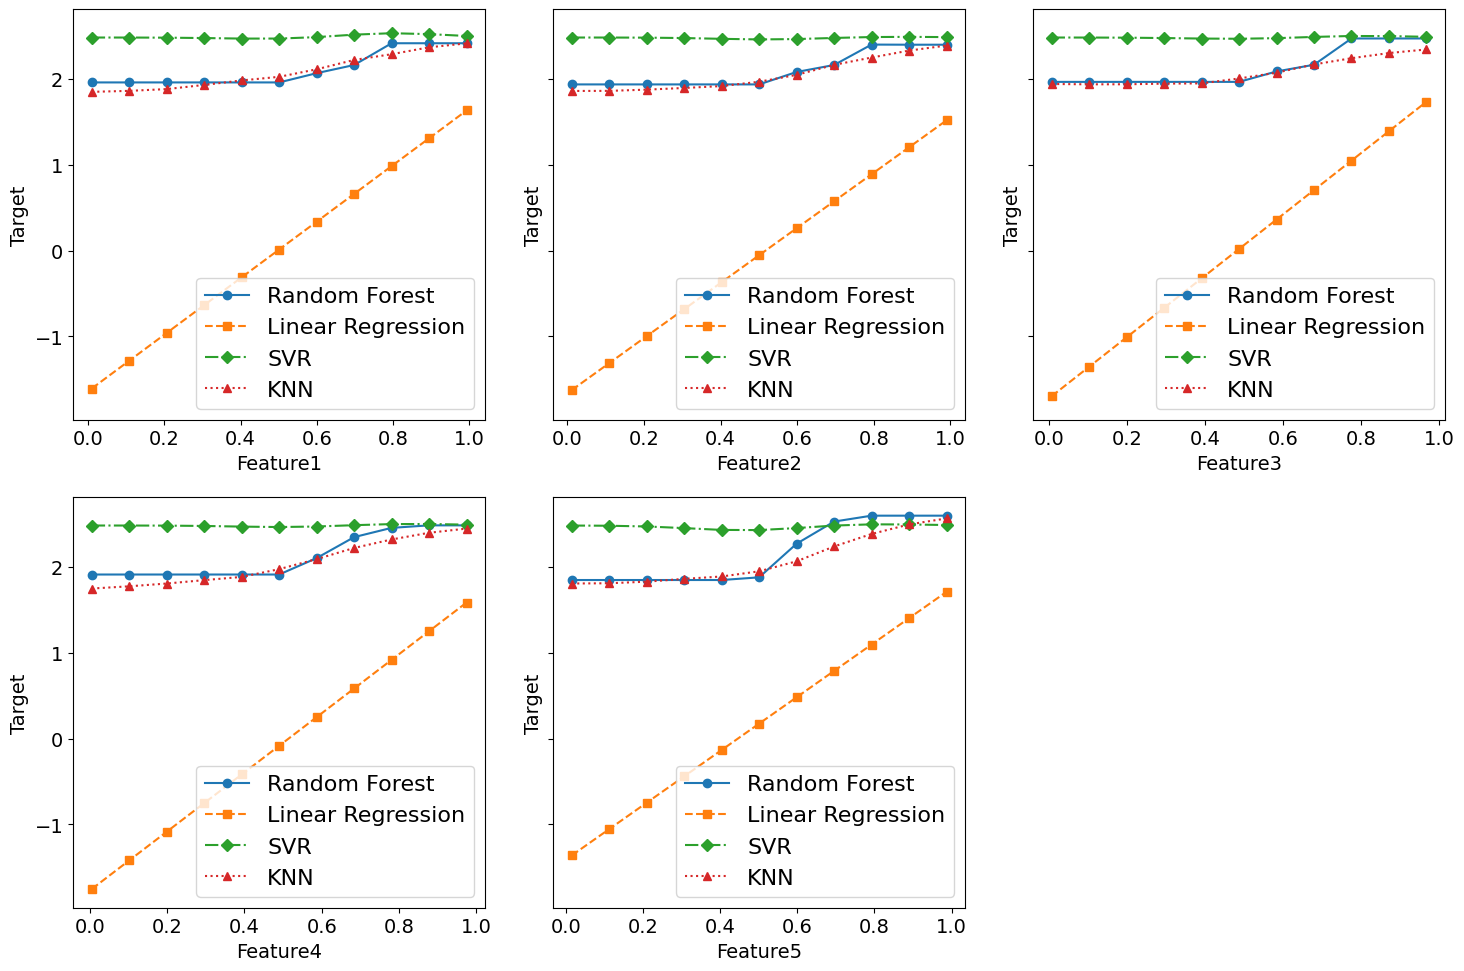

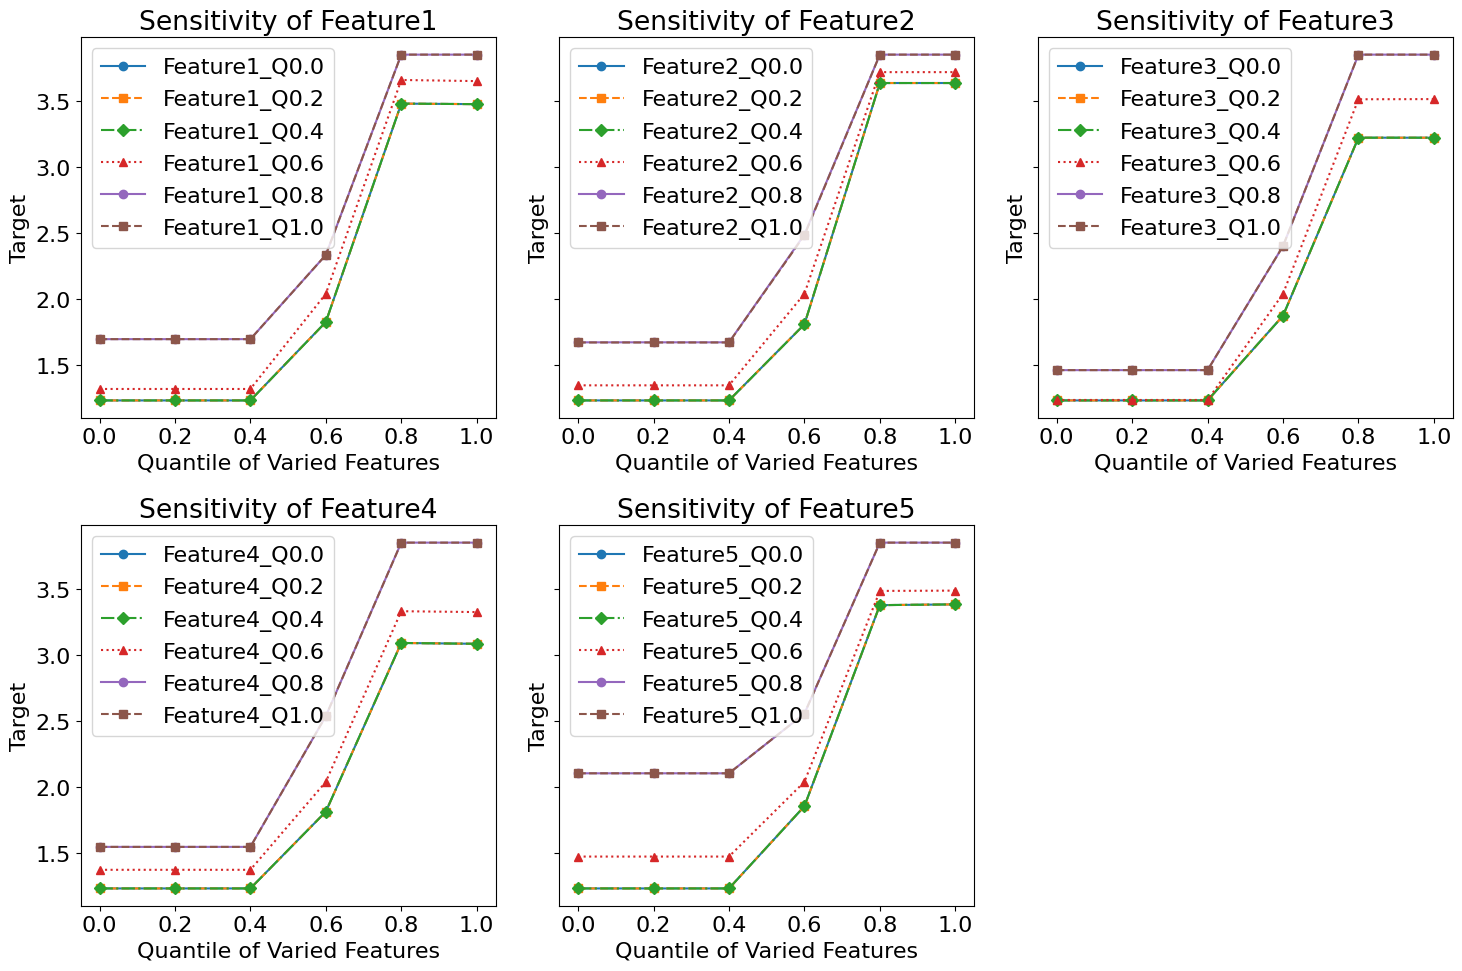

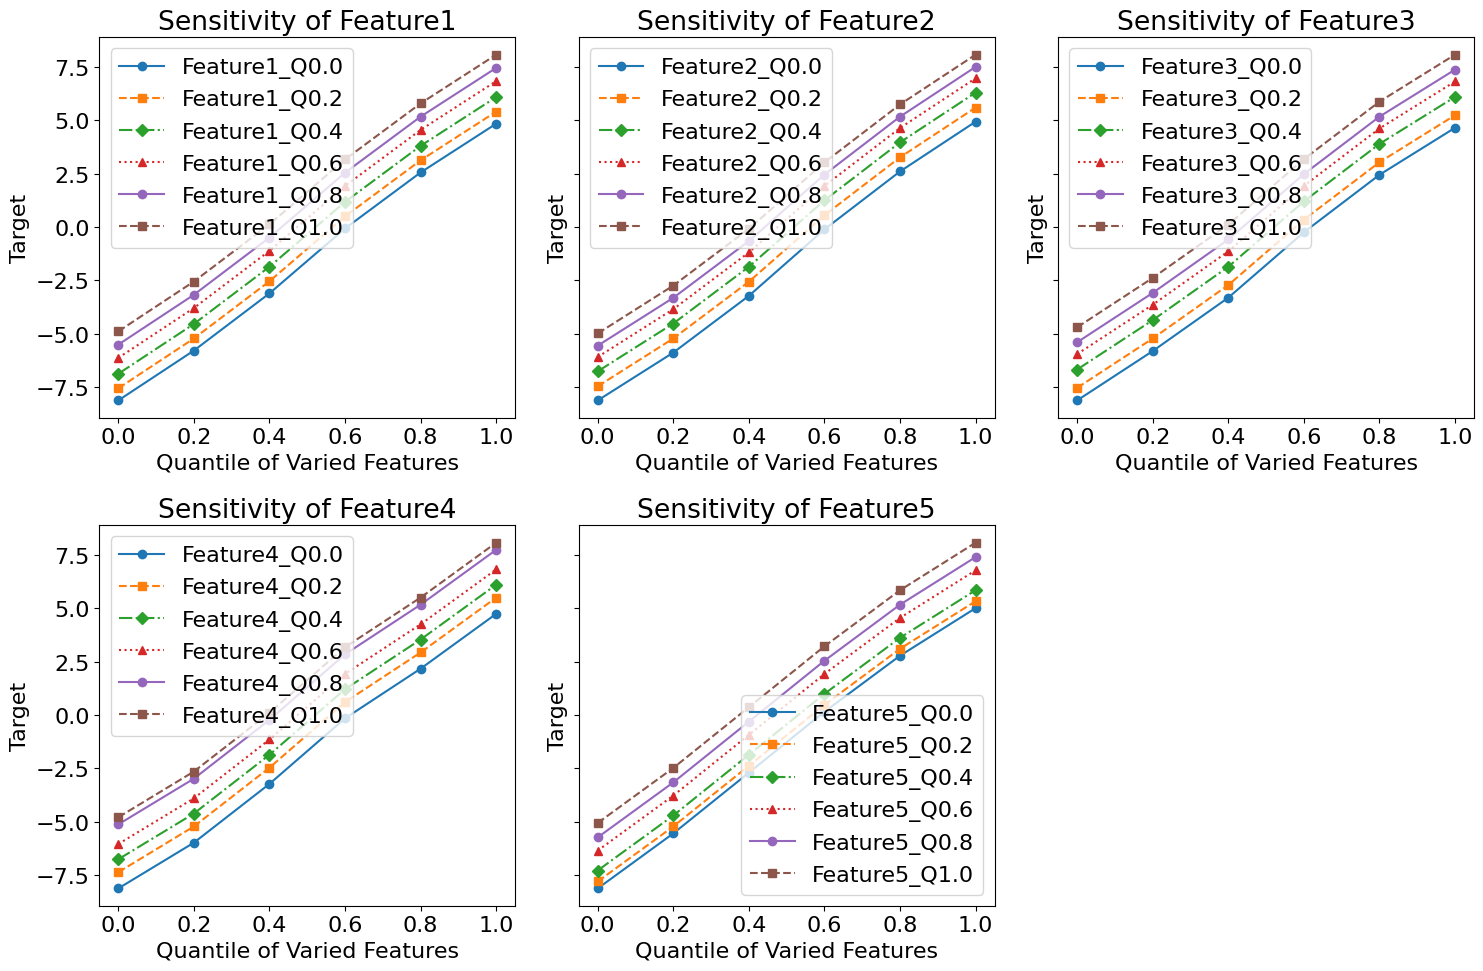

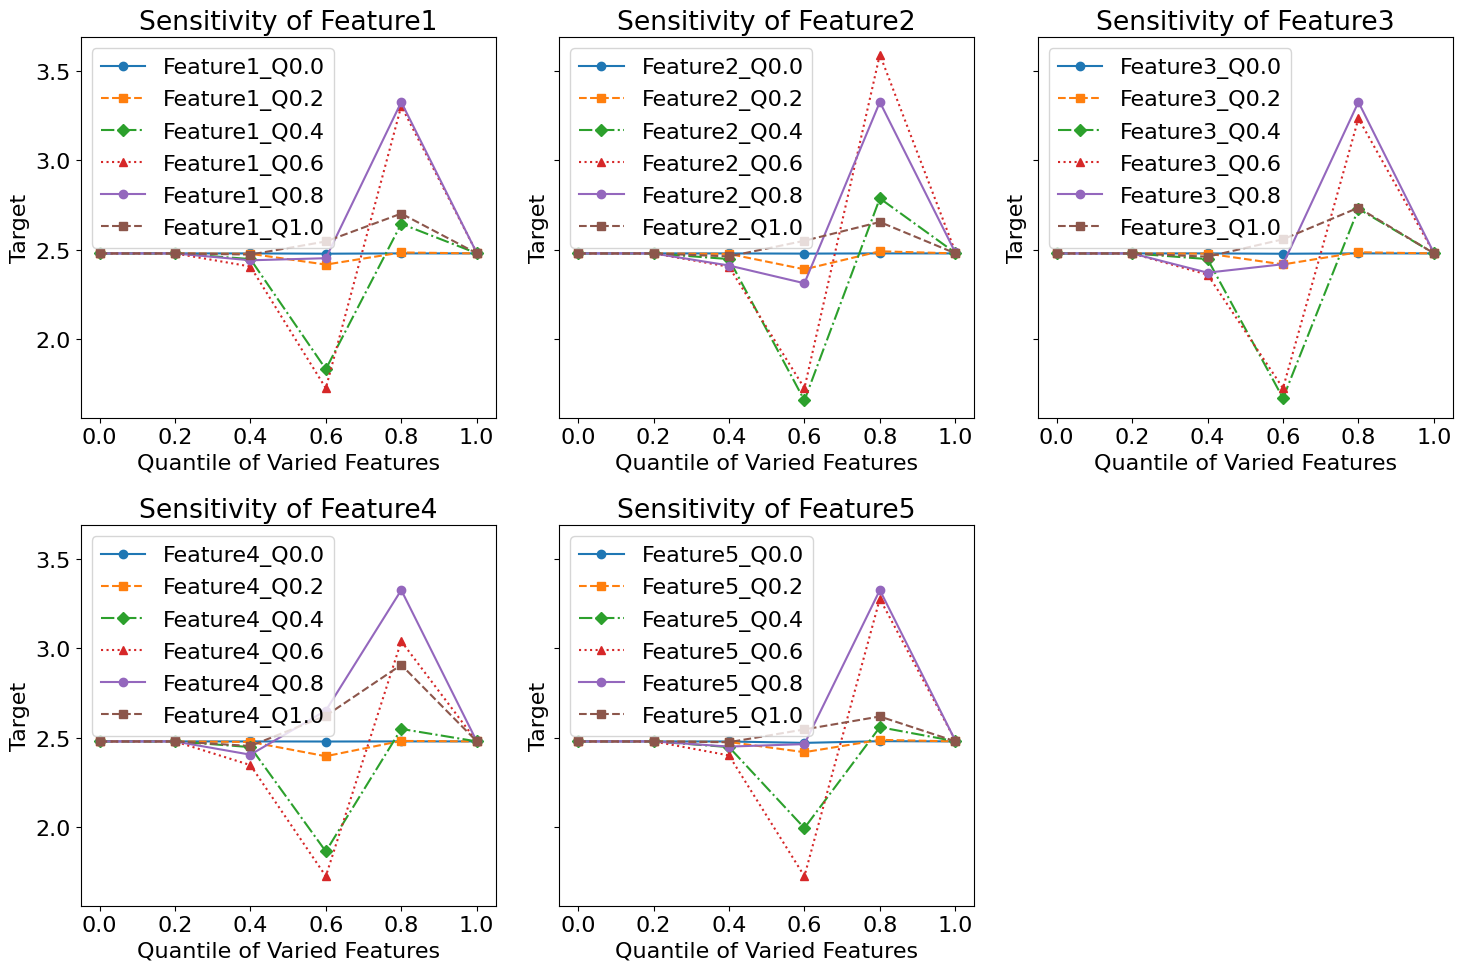

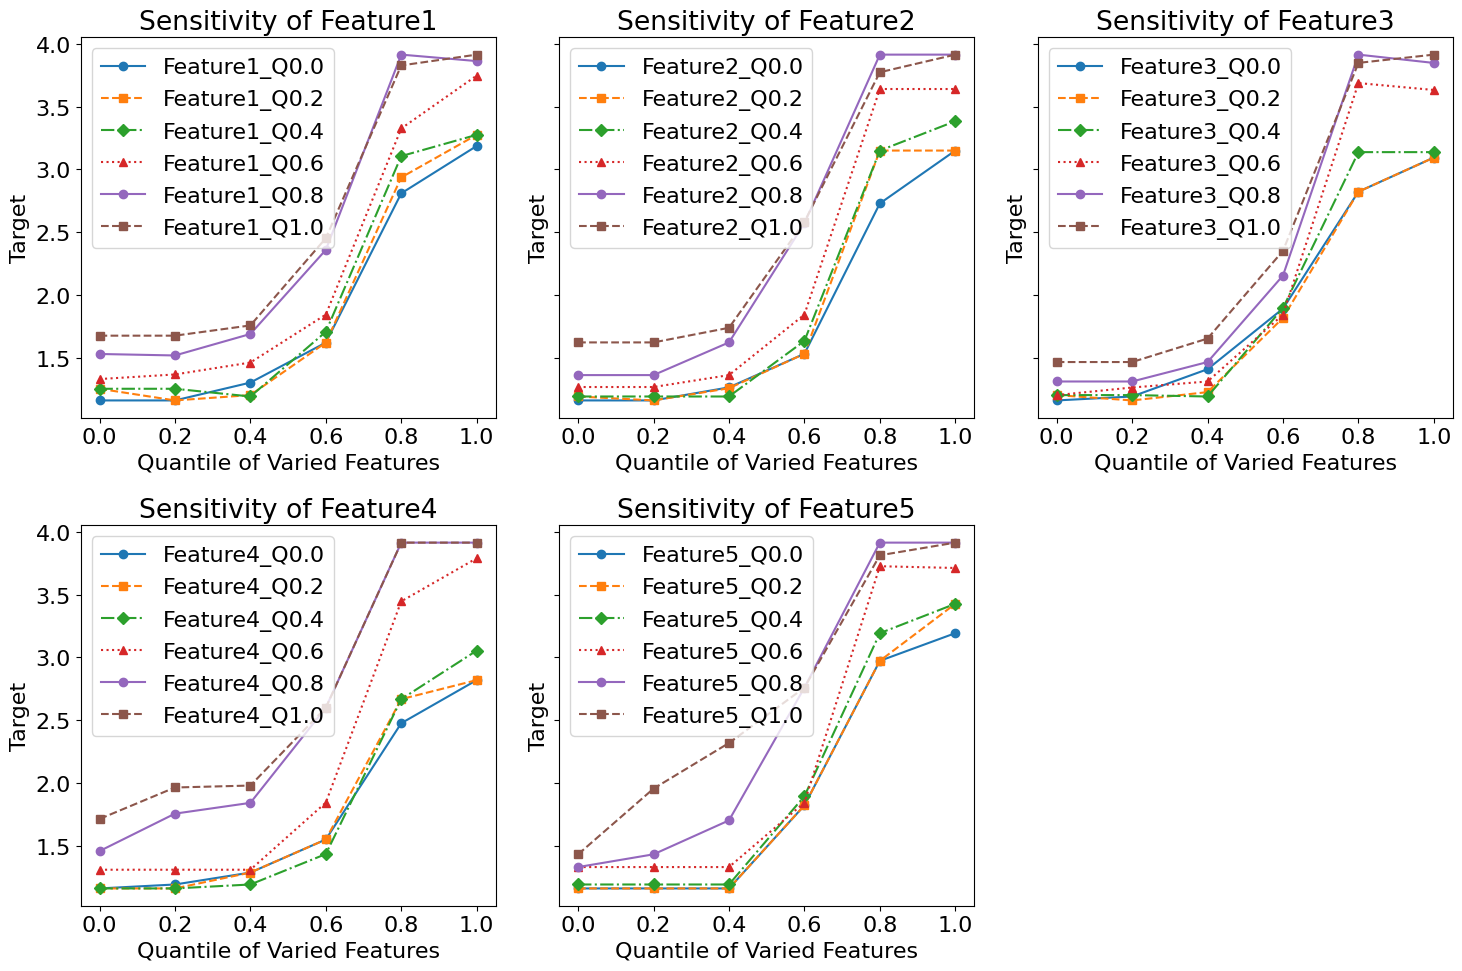

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from math import ceil, sqrt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from SensitivityAnalysis import SensitivityAnalysis



# Example usage
if __name__ == "__main__":
    # Generate synthetic dataset
    np.random.seed(42)
    data = pd.DataFrame(np.random.rand(100, 5), columns=["Feature1", "Feature2", "Feature3", "Feature4", "Feature5"])
    target = data.sum(axis=1) + np.random.normal(0, 0.1, 100)
    
    # Train example models
    rf_model = RandomForestRegressor()
    lr_model = LinearRegression()
    svr_model = SVR()
    knn_model = KNeighborsRegressor()
    
    rf_model.fit(data, target)
    lr_model.fit(data, target)
    svr_model.fit(data, target)
    knn_model.fit(data, target)
    
    # Initialize and run sensitivity analysis
    models = {"Random Forest": rf_model, "Linear Regression": lr_model, "SVR": svr_model, "KNN": knn_model}
    
    sa = SensitivityAnalysis(model=rf_model, data=data, feature_names=data.columns)
    sa.parametric_study(models)
    sa.parametric_sensitivity()
    
    sa2 = SensitivityAnalysis(model=lr_model, data=data, feature_names=data.columns)
    sa2.parametric_sensitivity()
    
    sa3 = SensitivityAnalysis(model=svr_model, data=data, feature_names=data.columns)
    sa3.parametric_sensitivity()
    
    sa4 = SensitivityAnalysis(model=knn_model, data=data, feature_names=data.columns)
    sa4.parametric_sensitivity()  